# ***Imports***  

In [1]:
import pandas as pd
import numpy as np
import os
import re
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')


In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
workers = os.cpu_count()
print(device)

cuda


In [3]:
# Dynamically determine batch size and mixed precision based on available resources
if torch.cuda.is_available():
    total_memory = torch.cuda.get_device_properties(0).total_memory
    batch_size = 32 if total_memory > 12e9 else 16
    use_fp16 = torch.cuda.get_device_capability(0)[0] >= 7
else:
    batch_size = 8
    use_fp16 = False

print(f"Determined batch size: {batch_size}, Mixed precision: {use_fp16}")

Determined batch size: 32, Mixed precision: False


# ***Data Loading***

In [4]:
# Load the dataset
df1 = pd.read_csv('/kaggle/input/phishingemails/Phishing_Email.csv')

df2 = pd.read_csv('/kaggle/input/phishing-email-dataset/CEAS_08.csv')
df2 = df2[['body', 'label']].rename(columns={'body': 'Email Text', 'label': 'Email Type'})
df2['Email Type'] = df2['Email Type'].map({0: 'Safe Email', 1: 'Phishing Email'})

df = pd.concat([df1, df2], ignore_index=True)
df.head()

,Unnamed: 0,Email Text,Email Type
0,0.0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1.0,the other side of * galicismos * * galicismo *...,Safe Email
2,2.0,re : equistar deal tickets are you still avail...,Safe Email
3,3.0,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4.0,software at incredibly low prices ( 86 % lower...,Phishing Email


In [5]:
df.isnull().sum()
df.head()

,Unnamed: 0,Email Text,Email Type
0,0.0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1.0,the other side of * galicismos * * galicismo *...,Safe Email
2,2.0,re : equistar deal tickets are you still avail...,Safe Email
3,3.0,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4.0,software at incredibly low prices ( 86 % lower...,Phishing Email


In [6]:
df.drop(["Unnamed: 0"],axis=1,inplace=True)
df.dropna(inplace=True,axis=0)
df.drop_duplicates(inplace=True)
print("Dimension of the row data:",df.shape)

Dimension of the row data: (56692, 2)


# ***Data Processing***

In [7]:
def preprocess_text(text):
    # Remove hyperlinks
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text
    
df['Email Text'] = df['Email Text'].fillna('').apply(preprocess_text)

df.head()

,Email Text,Email Type
0,re 6 1100 disc uniformitarianism re 1086 sex l...,Safe Email
1,the other side of galicismos galicismo is a sp...,Safe Email
2,re equistar deal tickets are you still availab...,Safe Email
3,hello i am your hot lil horny toy i am the one...,Phishing Email
4,software at incredibly low prices 86 lower dra...,Phishing Email


In [8]:

# Using email content as input features
X = df['Email Text']
y = df['Email Type']

# Initialize LabelEncoder
le = LabelEncoder()

# Assuming `y` contains the categorical labels like 'Safe Email' and 'Phishing Email'
y = le.fit_transform(y)

# Check the mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'Phishing Email': 0, 'Safe Email': 1}


In [9]:
# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
# Tokenizing the dataset
def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=512, return_tensors='pt')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Preparing the data for PyTorch
class EmailDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.device = device

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokenized_input = tokenize_function(self.texts[idx])
        input_ids = tokenized_input['input_ids'].squeeze(0).to(device)
        attention_mask = tokenized_input['attention_mask'].squeeze(0).to(device)
        label = torch.tensor(self.labels[idx], dtype=torch.long).to(device)
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': label}

In [12]:
# Create dataset objects
train_dataset = EmailDataset(X_train.tolist(), y_train.tolist())
test_dataset = EmailDataset(X_test.tolist(), y_test.tolist())

In [13]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='steps',
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    save_steps=100,
    save_strategy='steps',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    fp16=use_fp16,  # Dynamically determined mixed precision
    report_to='none'
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)



In [14]:
# Training the model
def train_model(trainer):
    trainer.train()

train_model(trainer)


Step,Training Loss,Validation Loss
100,0.219100,0.099058
200,0.082700,0.057467
300,0.068600,0.044141
400,0.053400,0.057893
500,0.041700,0.042721
600,0.060200,0.034822
700,0.039900,0.039385
800,0.053700,0.027420
900,0.033100,0.024612
1000,0.037500,0.024586


In [15]:
# Evaluation with Metrics Visualization
def evaluate_model(trainer, test_dataset):
    # Model predictions
    predictions, labels, _ = trainer.predict(test_dataset)
    predicted_labels = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predicted_labels)
    precision = precision_score(labels, predicted_labels, average='binary') 
    recall = recall_score(labels, predicted_labels, average='binary')  
    f1 = f1_score(labels, predicted_labels, average='binary')        
    roc_auc = roc_auc_score(labels, predicted_labels)
    cm = confusion_matrix(labels, predicted_labels)
    tn, fp, fn, tp = cm.ravel()
    print("Accuracy: {:.2f}%".format(acc * 100))
    print("Precision: {:.2f}%".format(precision * 100))
    print("Recall: {:.2f}%".format(recall * 100))
    print("F1 Score: {:.2f}%".format(f1 * 100))
    print("ROC AUC Score: {:.2f}%".format(roc_auc * 100))
    print("False Positives: {}".format(fp))
    print("False Negatives: {}".format(fn))
    print("Classification Report:")
    print(classification_report(labels, predicted_labels, target_names=le.classes_))

    # Plotting Accuracy, Precision, Recall
    plt.figure(figsize=(10, 5))
    plt.bar(['Accuracy', 'Precision', 'Recall'], [acc * 100, precision * 100, recall * 100], color='skyblue')
    plt.title('Model Evaluation Metrics')
    plt.ylabel('Percentage')
    plt.show()

    # Plotting TP, FN, FP, TN
    plt.figure(figsize=(10, 5))
    plt.bar(['TP', 'FN', 'FP', 'TN'], [tp, fn, fp, tn], color='lightcoral')
    plt.title('Confusion Matrix Components')
    plt.ylabel('Count')
    plt.show()

# Plotting ROC Curve
    fpr, tpr, _ = roc_curve(labels, predicted_labels)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# ***Evaluation***

Accuracy: 99.41%
Precision: 99.19%
Recall: 99.63%
F1 Score: 99.41%
ROC AUC Score: 99.41%
False Positives: 46
False Negatives: 21
Classification Report:
                precision    recall  f1-score   support

Phishing Email       1.00      0.99      0.99      5697
    Safe Email       0.99      1.00      0.99      5642

      accuracy                           0.99     11339
     macro avg       0.99      0.99      0.99     11339
  weighted avg       0.99      0.99      0.99     11339



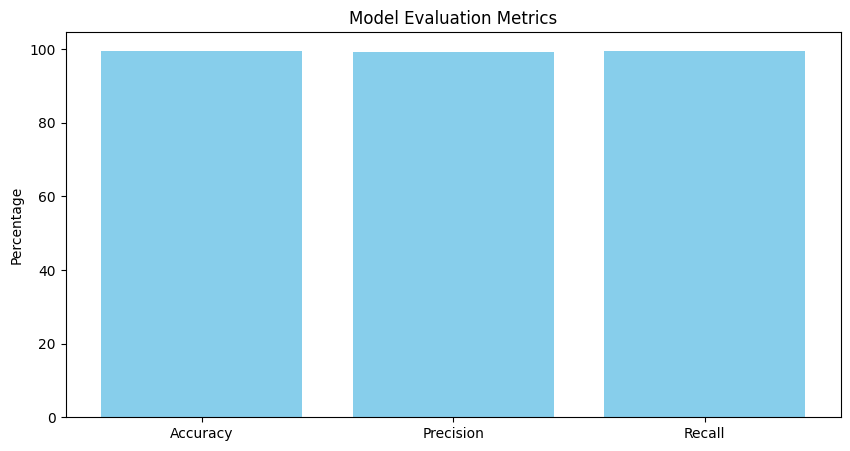

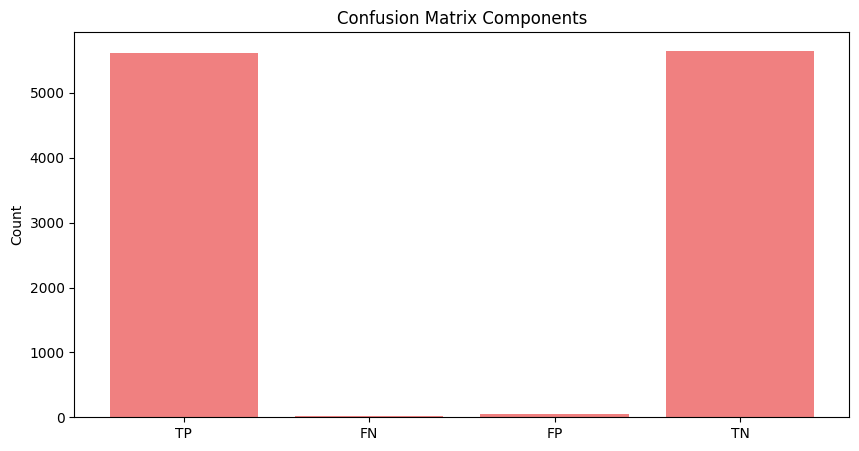

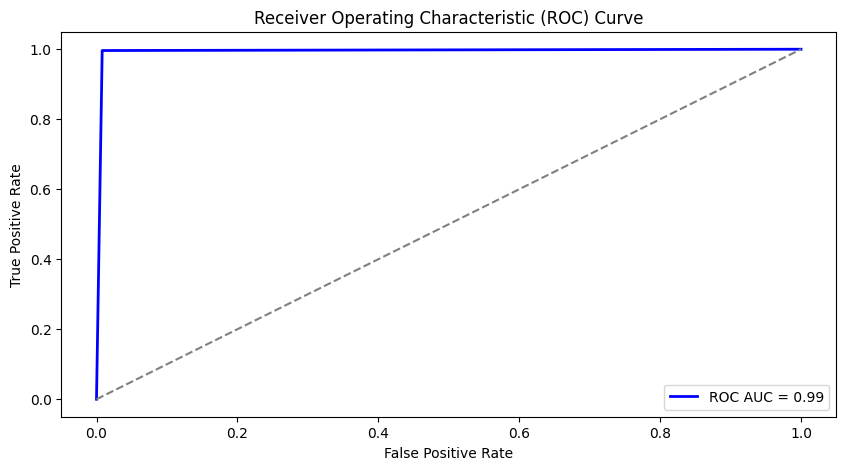

In [16]:
# Evaluate the model on test data
evaluate_model(trainer, test_dataset)

# ***Adversarial Training***


Evaluating on Adversarial Examples:


Accuracy: 99.40%
Precision: 98.83%
Recall: 100.00%
F1 Score: 99.41%
ROC AUC Score: 99.39%
False Positives: 6
False Negatives: 0
Classification Report:
                precision    recall  f1-score   support

Phishing Email       1.00      0.99      0.99       494
    Safe Email       0.99      1.00      0.99       506

      accuracy                           0.99      1000
     macro avg       0.99      0.99      0.99      1000
  weighted avg       0.99      0.99      0.99      1000



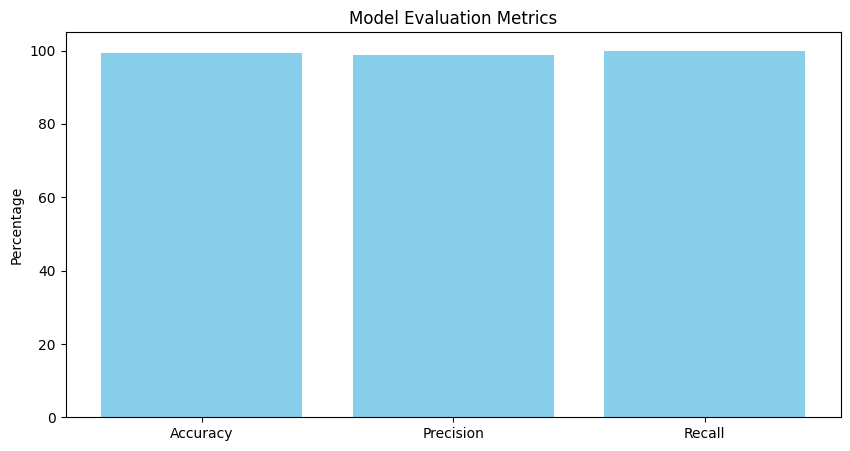

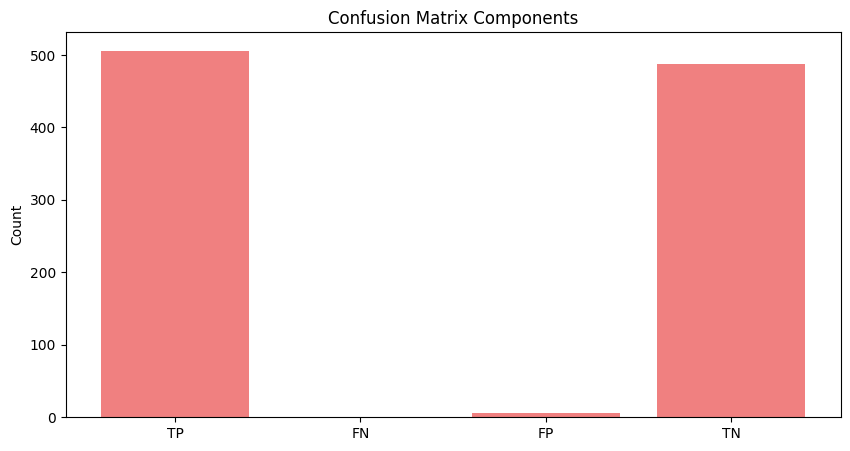

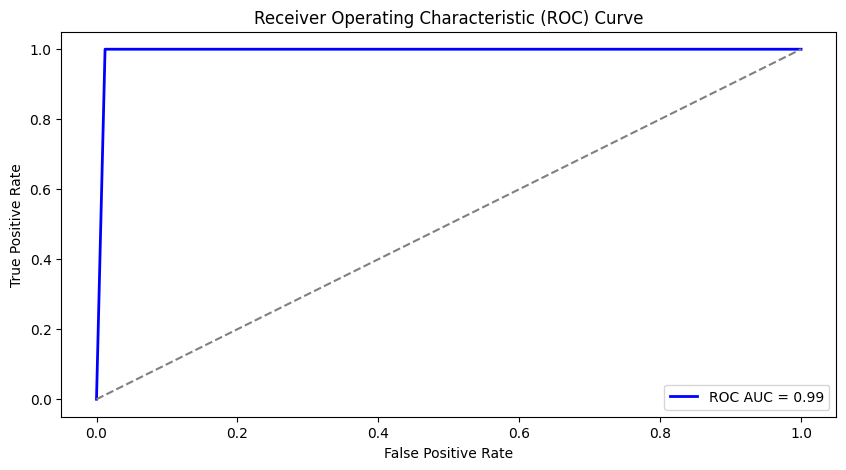

In [17]:
# Implement Adversarial Training for Robustness
def adversarial_training(dataset, model, tokenizer, num_adversarial_examples=1000):
    # Common words often used in phishing emails
    phishing_keywords = ["bank", "account", "password", "login", "verify", "security", "urgent", "immediate", "credit", "transaction"]

    adversarial_texts = []
    for i in range(num_adversarial_examples):
        original_text = dataset.texts[i]
        modified_text = original_text
        for keyword in phishing_keywords:
            if keyword in modified_text:
                modified_text = modified_text.replace(keyword, keyword.replace('a', '@').replace('o', '0').replace('e', 'ë').replace('i', 'ï'))
        adversarial_texts.append(modified_text)

    adversarial_labels = dataset.labels[:num_adversarial_examples]
    adversarial_dataset = EmailDataset(adversarial_texts, adversarial_labels)

    # Evaluate on adversarial examples
    print("\nEvaluating on Adversarial Examples:")
    evaluate_model(trainer, adversarial_dataset)



# Perform adversarial evaluation
adversarial_training(test_dataset, model, tokenizer)
